### Scale detection using chroma features

This notebook (prepared by Emir Demirel) demonstrates the usage of Chroma features for scale-detection task. There are 4 sections in this demonstration. 
- First, we will extract Chroma / HPCP features of a single audio file. 
- In the second part, we will apply the same method for all the files in ScalesDataset*. At this step we will observe certain aspects of chroma features (like #ofbins, etc.) Then, the proposed method for scale detection will be shown. 
- For the third step, we will apply our methodology over a dataset that consists of tracks from a different music tradition. We will observe the necessary modifications on parameters.
- Questions & Discussions.

INITIAL STEP: Download the sound from Freesound.org

In [1]:
import sys,os
import freesound
import urllib.request
import shutil
client = freesound.FreesoundClient()
#You are expected to place your token in the line below
client.set_token("...yourTokenGoesHere...","token")
targetDir='../../data/scaleDetection/'
if not os.path.exists(targetDir):#creating the directory
    os.mkdir(targetDir);
queryStrings=["jazz-phrase"]
for queryStr in queryStrings:
    results = client.text_search(query=queryStr,fields="id,name,previews,tags")
    cnt=0
    for sound in results:
        #print(sound.name)
        sound.retrieve_preview(targetDir+".",sound.name+".wav")
        os.rename(targetDir+sound.name+".wav",targetDir+queryStr+"_"+str(cnt)+".wav")
        cnt=cnt+1
        if cnt>=2:
            break
url='https://sites.google.com/site/mirspring2018/resources/extractedfeaturesfor--12bins.pkl?attredirects=0&d=1'
filename='extractedfeaturesfor--12bins.pkl'
#Downloading the pickle file from the url
urllib.request.urlretrieve(url,targetDir+filename)            
print("Files are copied! check your folder")

Files are copied! check your folder


Set the environment.
Load necessary functions

In [2]:
import os
import sys
import pickle
import csv
import numpy as np
import essentia.standard as ess
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd
import json

#Container for analysis parameters
class AnalysisParams:
    def __init__(self,windowSize,hopSize,windowFunction,fftN,fs):
        
        self.windowSize = windowSize
        self.hopSize = hopSize
        self.windowFunction = windowFunction
        self.fftN=fftN
        self.fs=fs

def initiateData4File(file,root):
     
    fileData=dict();fileData['name']=file.split('.')[0];fileData['path']=root;
    fileData['numBin']=[]; #number of bins per octave
    fileData['hpcp']=[]; #the list of frame-based hpcp vectors
    fileData['mean_hpcp_vector']=[]; #means of HPCP bins
    fileData['std_hpcp_vector']=[]; #standard deviation of HPCP bins
    #data from Ground Truth
    fileData['groundtruth']=[];
    fileData['key']=[]; #tonic Info
    
    return fileData

def computeReferenceFrequency(tonic,tuningfreq):    #computation of the reference frequency for HPCP vector from the tonic of the audio segment
    keys = {'A':0,'Bb':1,'B':2,'C':3,'C#':4,'D':5,'Eb':6,'E':7,'F':8,'F#':9,'G':10,'G#':11}
    for key in keys:
        if key == tonic:
            ref_freq = tuningfreq * (2**((keys[key]*100)/1200)) /2 #compute reference frequency according to the key (tonic) of the audio file
                                                     #divide the results by 2 the get one octave lower pitch as the reference freq
            return ref_freq

STEP 1: Analysis of a single Audio File. (# of bins = 12) File : Simple improvisation in Bb.

Computation HPCP features:
- Create proper structure for the audio file to store necessary information
- Load the audio using ess.MonoLoader
- Apply frame-based analysis using ess.FrameGenerator. We set the windows size as big as 200ms to be able to extract meaningful estimations regarding pitch info.
- Extract the spectral peaks using ess.SpectralPeaks. This returns the frequency and magnitude information the detected peaks.
- Extract frame based HPCP vectors using ess.HPCP. Here we normalize our vector to unitSum norm (HPCP[i]/np.sum(HPCP) : i in range(numBin))
- Set the reference frequency (Bin#0) as the tonal center of the performance. Here, in this case we know that it is in Bb. So we input the frequency of Bb3 as the referenceFrequency.

In [3]:
params=AnalysisParams(200,100,'hann',2048,44100)
fs = 44100
windowSize=round(fs*params.windowSize/1000);windowSize=int(windowSize/2)*2#assuring window size is even
hopSize=round(fs*params.hopSize/1000);hopSize=int(hopSize/2)*2#assuring hopSize is even
numBins=12
hpcp=[]
for file in os.listdir(targetDir):
    if file.endswith('phrase_1.wav'):
        fileName = os.path.join(targetDir,file)
        fileData=initiateData4File(file,targetDir)
        x = ess.MonoLoader(filename = fileName, sampleRate = fs)()
        for frame in ess.FrameGenerator(x, frameSize=windowSize, hopSize=hopSize, startFromZero=True):
            frame=ess.Windowing(size=windowSize, type=params.windowFunction)(frame)
            mX = ess.Spectrum(size=windowSize)(frame)
            mX[mX<np.finfo(float).eps]=np.finfo(float).eps
            freq,mag = ess.SpectralPeaks()(mX) #extract frequency and magnitude information by finding the spectral peaks    
            reffreq = computeReferenceFrequency('Bb',440)## computation of reference frequency for the chroma vector
            hpcp.append(ess.HPCP(normalized='unitSum',referenceFrequency=reffreq,size = numBins, windowSize = 12/numBins)(freq,mag)) #harmonic pitch-class profiles
        fileData['hpcp']=np.array(hpcp);
        

PLOTTING & VISUALIZATION

<class 'numpy.ndarray'>


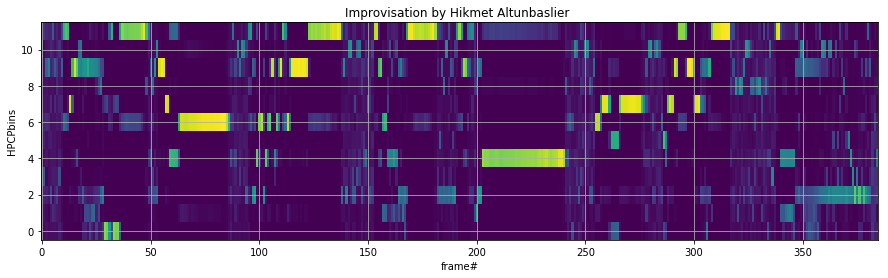

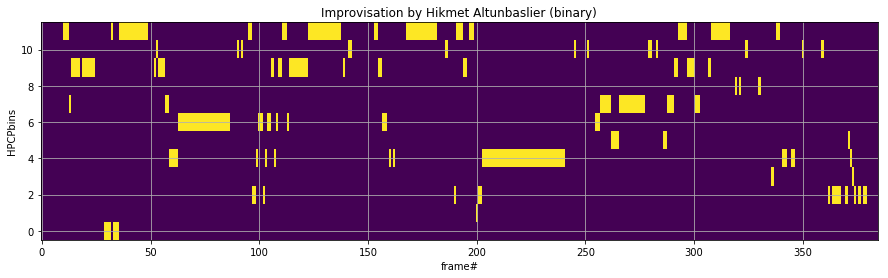

In [4]:
hpcparray=[];
singlefile = fileData
#scale = singlefile['groundtruth']['scaleType'].split(':')[1]

for i in range(len(singlefile['hpcp'])):
    hpcparray.append(singlefile['hpcp'][i])
globalhpcparray=np.array(hpcparray)
print(type(globalhpcparray[0]))
temp=globalhpcparray.transpose()

plt.figure(figsize=(15,4))
plt.imshow(temp, interpolation='nearest',origin='lower')
plt.title('Improvisation by Hikmet Altunbaslier ')
plt.ylabel('HPCPbins')
plt.xlabel('frame#')
plt.axis('tight') 
plt.grid(True)
plt.show()

bin_representation=[];
for j in range(len(globalhpcparray)):
    bin_representation.append(np.where(globalhpcparray[j]>0.45,1,0))#set a threshold for binarization
        
bin_plot = np.array(bin_representation)
temp1=bin_plot.transpose()

plt.figure(figsize=(15,4))
plt.imshow(temp1, interpolation='nearest',shape=(12,5),origin='lower')
plt.title('Improvisation by Hikmet Altunbaslier (binary)')
plt.ylabel('HPCPbins')
plt.xlabel('frame#')
plt.axis('tight')
plt.grid(True)
plt.show()

STEP 2: Analysis of the ScalesDataset. 
- At this step, we consider certain tracks within the scales dataset to demonstrate a possible usage of HPCP features for the scale detection task. We only consider the tracks with major and minor scale performances.
- Let's start with visualizing globalHPCP features of audio slices grouped by scaleTypes.

!!!!!! CHECKPOINT / INITIALIZATION !!!!!!

In [5]:
numBin=12 ##choose from 12,24,36,48 manually.
scaleTypes=['major','minor']
#Load the related pickle file to process the extraced features. With this .pkl file, we do not have to extract features each time.
with open(targetDir+'extractedfeaturesfor--'+str(numBin)+'bins.pkl', 'rb') as f:
    data = pickle.load(f)

print('Scales in this dataset: ',scaleTypes)

HPCPscales=dict()#dictionary including dictionaries scale->feature->data
#scale = 'lydian' #choose explicitly which scale to visualize (TODO for automatically)
for scale in scaleTypes:
    for fileName, parts in data.items():
        if fileName.find(scale) != -1:
            for part in parts:
                scaletype = part['groundtruth']['scaleType'].split(':')[1]
                if scaletype == scale: #if scale matches with ground truth
                                       #put them in the same container
                    filescale=HPCPscales.get(scale)
                    if filescale==None:
                        filescale=[part['mean_hpcp_vector']]  ##you can change to see the std hpcp vectors
                    else:
                        filescale.append(part['mean_hpcp_vector'])
                HPCPscales[scale]=filescale
                

Scales in this dataset:  ['major', 'minor']


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


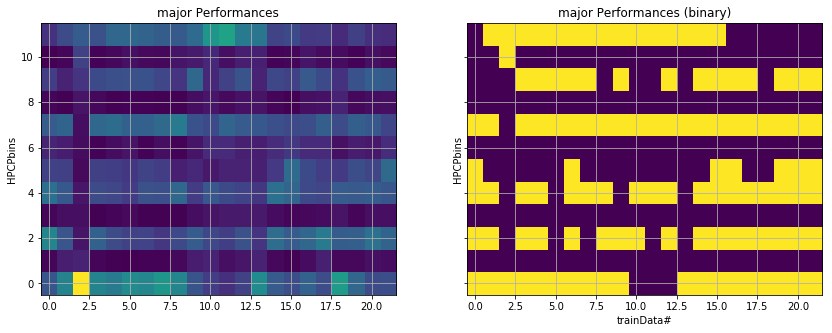

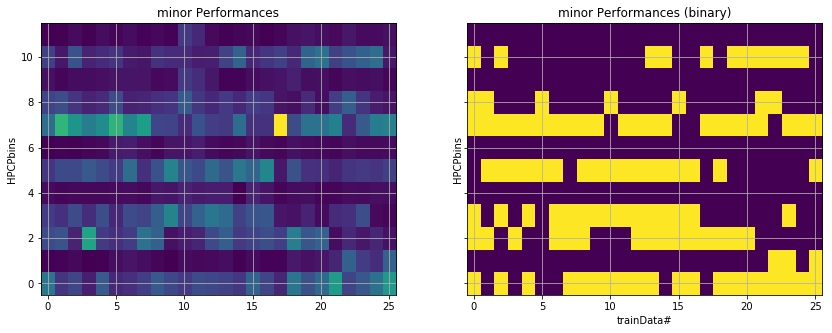

In [6]:
imagenumber=1

for scale in scaleTypes:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
    
    hpcparray=[];
    for i in range(len(HPCPscales[scale])):
        hpcparray.append(HPCPscales[scale][i])
    globalhpcparray=np.array(hpcparray)
    print(type(globalhpcparray[0]))
    temp=globalhpcparray.transpose()
    
    ax1.imshow(temp, interpolation='nearest',origin='lower')
    
    ax1.set_title(scale +' Performances')
    ax1.set_ylabel('HPCPbins')
    ax2.set_xlabel('trainData#')
    ax1.axis('tight') 
    ax1.grid(True)

    bin_representation=[];
    for j in range(len(globalhpcparray)):
        bin_representation.append(np.where(globalhpcparray[j]>0.095,1,0))#TODO parametric      
    bin_plot = np.array(bin_representation)
    temp1=bin_plot.transpose()
    #plt.figure(figsize = (10,5))
    ax2.imshow(temp1, interpolation='nearest',shape=(12,5),origin='lower')
    ax2.set_title(scale +' Performances (binary)')
    ax2.set_ylabel('HPCPbins')
    ax2.set_xlabel('trainData#')
    ax2.axis('tight')
    ax2.grid(True)

CLASSIFICATION: 
Let's apply some MachineLearning for the classification of our data into scale categories.

The scripts below show our approach of using HPCP features for classification.
We take each bin in our HPCP vectors as a single feature in our feature space. Then we classify our audio phrases according to these features using Support Vector Machine classifier.

To easily process our data, let's dump necessary data into .csv file.

In [7]:
#Convert data to .csv File

with open(targetDir+'extractedfeaturesfor--12bins.pkl', 'rb') as f: ###Try different .pkl files to show the effect of changing the number of bins
    data = pickle.load(f)

fieldnames=['name']
#for i in range(len(data['toprak_major'][0]['mean_hpcp_vector'])):
 #   ind=str(i)
  #  fieldnames.append('mean_hpcp'+ind)
for i in range(len(data['toprak_major'][0]['std_hpcp_vector'])):
    ind=str(i)
    fieldnames.append('std_hpcp'+ind)    
fieldnames.append('scaleType')
dataList=[]
dataList.append(fieldnames)
for fileName, parts in data.items(): ##navigate in dictionary
    for part in parts: #search within audio slices
        tempList=[] #temporary List to put attributes for each audio slice (data-point)
        dataname = part['name']+'_'+part['groundtruth']['name'] #name of data
        tempList.append(dataname)
        for i in range(len(data['toprak_major'][0]['mean_hpcp_vector'])): #append mean_HPCP vector bins separately            
            tempList.append(part['mean_hpcp_vector'][i])
        #for i in range(len(data['toprak_major'][0]['mean_hpcp_vector'])): #append mean_HPCP vector bins separately            
         #   tempList.append(part['std_hpcp_vector'][i])    
        tempList.append(part['groundtruth']['scaleType'].split(':')[1])    #append scales for classification
        dataList.append(tempList)
            
with open(targetDir+'mycsvfile.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(dataList)

Definition of the functions for the machine learning work flow using scikit-learning.

- computeScores(X,Y,c)
X = feature data, Y = categores (class label), c = sk.svm.LinearSVC parameter to be optimized.
This function computes the classification scores using Support Vector Machines.
- svc_param_selection(X,Y,nfolds)
This function finds the best parameter for LinearSVC using GridSearch algorithm and applying 10-fold cross validation using the train set.
- plot_confusion_matrix(cm, classes)
This function plots the confusion matrix for the test data that is predicted.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools

def computeScores(X,Y,c):
     
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, stratify = Y)
    param=svc_param_selection(X_train,Y_train,10)
    print(param)
    
    estimators = []
    model2 = LinearSVC(C=c)
    estimators.append(('classify',model2))
    model = Pipeline(estimators)
    Y_pred=model.fit(X_train, Y_train).predict(X_test)
    
    cm = confusion_matrix(Y_test, Y_pred)
    scaleTypes=['major','minor']
    plot_confusion_matrix(cm,scaleTypes)
    crosvalfold=5
    scores = cross_val_score(model,X,Y,cv=crosvalfold, n_jobs=-1)
    print(scores)
    print(np.sum(scores)/crosvalfold)
    
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
    #gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(LinearSVC(multi_class='ovr'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect = 'auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


PARAMETER OPTIMIZATION: GridSearchCV
CLASSIFIER : LinearSVC (support vector machine)
TRAIN & TEST :2-FOLD cross validation

{'C': 1}
Confusion matrix, without normalization
[ 1.  1.  1.  1.  1.]
1.0


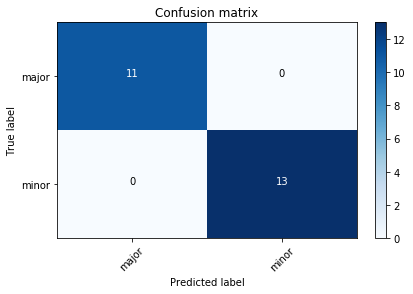

In [9]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 

dataclass=[];
file = targetDir+'mycsvfile.csv'
df = pd.read_csv(file)
df.pop('name');
#df.pop('mean_hpcp0')
dataclass=df.pop('scaleType');
X=df
Y=dataclass

computeScores(X,Y,1)